## Introduction
This homework is programming based, where you must use Python to explore the fitting and generalization of regression models via simulation.  
Suppose that $Y$ and $Y$ are both real valued random variables, where $X$ takes value in $(0, 1)$ and $Y$ depends on $X$ according to

>$$Y = cos(2 \pi X) + Z ..................... (1)$$  

where $Z$ is a zero mean Gaussian random variable with variance $\sigma$, and $Z$ is independent of $X$. But assume
that you do not know this dependency of $Y$ on $X$ and that you only observe a sample of $N (X, Y)$ pairs.
Based on the observed sample, you must learn a polynomial regression model and examine the fitting and
generalization capability of your model in relation to the model complexity and sample size.  
Below detailed instructions are given to guide you through this exercise. These instructions only serve as a guideline, which your implementation need not to rigorously follow. You must use Python to write your code. It is fine and encouraged, but NOT compulsory, if you use a Python package that does automatic differentiation. But you must implement manually gradient-based optimization. That is, the
use of the package is only for you to compute the required gradients and you must manually code up the update of model parameters. You need to submit the following deliverables.  
* All Python code
* A concise report explaining your findings.

In [1]:
import torch
import tensorflow as tf
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We need DCG_node to check all attributes

In [2]:
def DCG_node(listValue):
    for (i, v) in enumerate(listValue):
        print(f"{i}.data: {v.data}\n{i}.requires_grad: {v.requires_grad}\n{i}.grad: {v.grad}\n{i}.grad_fn: {v.grad_fn}\n{i}.is_leaf: {v.is_leaf}\n")

## getData

Write a function **getData** that generates a dataset ${(x_i, y_i) : i = 1, 2, ... N}$ g of $N (X, Y)$ pairs for a given value of $N$ and $\sigma$. The $X$ values are drawn uniformly at random from $(0, 1)$ and the corresponding $Y$ values are generated according to (1).  
The dataset created by **getData** will then be used to fit your regression models. Of course, in the design of your regression model, you should assume no knowledge on how the dataset is generated.  
The regression models we consider will be exclusively polynomial models, namely, predicts $Y$ from $X$ according to
$$Y = a_0 + a_1X + a_2X^2 + ... + a_dX^d$$
where $d$ is the polynomial degree and $a_i$'s are coefficients to be estimated.

In [3]:
def getData(N: int, sigma: float, plot = False):
    X = torch.empty(N,).uniform_(0, 1).type(torch.FloatTensor)
    f = torch.cos(2 * np.pi * X)
    Z = torch.normal(0, sigma ** 2, size=(N,))
    Y = f + Z
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=X, y=f, color='red', label = 'f(x)', ax=ax)
        sns.scatterplot(x=X, y=Y, color='blue', label='training data', ax=ax);
        plt.title("getData")
    return [(xi, yi) for (xi, yi) in zip(X, Y)]

(500, 2)

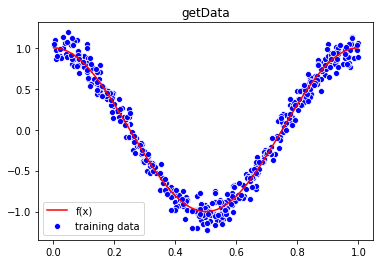

In [4]:
np.shape(getData(500, 0.3, plot=True))

## Pytorch

### getMSE

Write a function **getMSE** which computes the mean square error (MSE) for a given dataset fitted to a specified polynomial.

In [159]:
# MSE = (1/N) sum ((Y - (1, x, x ^ 2, ... x ^ d) * A) ^ 2)
# A.size() = (d + 1, 1)
# x.size() = (N, 1)
# Y_real.size() = (N, 1)
def getMSE(Y_real, x, A, y_pred=False):
    if A.grad != None:
        A.grad.data.zeros_()
    A.requires_grad = True
    D = A.size()[0] - 1
    N = x.size()[0]
    X = torch.cat(([(x ** i).view(N, 1) for i in range(D+1)]), dim=1)
    # print(f"MSE test: A is {A.size()}, X is {X.size()}")
    Y_pred = torch.matmul(X, A)
    # print(f"in getMSE: X is {X.size()}, A is {A.size()}, Y_pred is {Y_pred.size()}")
    if y_pred:
        return ((1 / N) * torch.sum((Y_real - Y_pred) ** 2), Y_pred)
    else:
        return (1 / N) * torch.sum((Y_real - Y_pred) ** 2)

In [ ]:
# test it the result should be [1.5, 2.5, 6.5]
x = torch.FloatTensor([0, 1, 2, 3])
Y_real = torch.FloatTensor([0, 2, 4, 9])
A = torch.tensor([1.0, 0, 1.0])
L = getMSE(Y_real, x, A)
L.backward()
print(DCG_node([Y_real, x, A, L]))


0.data: tensor([0., 2., 4., 9.])
0.requires_grad: False
0.grad: None
0.grad_fn: None
0.is_leaf: True

1.data: tensor([0., 1., 2., 3.])
1.requires_grad: False
1.grad: None
1.grad_fn: None
1.is_leaf: True

2.data: tensor([1., 0., 1.])
2.requires_grad: True
2.grad: tensor([1.5000, 2.5000, 6.5000])
2.grad_fn: None
2.is_leaf: True

3.data: 0.75
3.requires_grad: True
3.grad: None
3.grad_fn: <MulBackward0 object at 0x7f397a76f6d8>
3.is_leaf: False

None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  This is separate from the ipykernel package so we can avoid doing imports until


### fitData

Write a function **fitData** that estimates the polynomial coefficients by fitting a given dataset to a degree-d polynomial. The function returns the following:  
1. The estimated polynomial coefficients. The estimation of the coefficients should be based on GD/ SGD /mini-batched SGD.  
**To achieve mini-batched SGD, just select a batch of samples and use several batches in one epoch；in each batch, calculate MSE for selected samples and do backward().**  
**To achieve SGD, just pick up one random sample and calculate MSE then do backward()**
2. The MSE of the dataset fitted to the estimated polynomial. This MSE will be denoted by $E_{in}$.
3. $E_{out}$. To obtain this value, your function needs to generate a separate large testing dataset (say,
containing 1000 or 2000 data points) using **getData** and under the same setting of $\sigma$ and compute
the MSE of the testing dataset fitted to the estimated polynomial.
The computation of $E_{in}$ and $E_{out}$ calls **getMSE**.

#### fitData_DG


In [168]:
def fitData_DG(Y_real, x, A, 
               epochs=3000, 
               r=0.1,  
               plot=True, 
               N_test=2000, 
               sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data, degree-d
    N = x.size()[0] # get number of sample
    L = getMSE(Y_real, x, A.detach_())
    # print(f"fitData is DG")
    while epoch < epochs:
        L.backward()
        A = (A - r * A.grad.data).detach() # make A a leaf node
        L = getMSE(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

x is torch.Size([200]), y is torch.Size([200]), A is torch.Size([11])
time cost is 2.5774855613708496


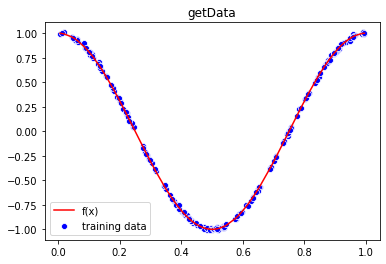

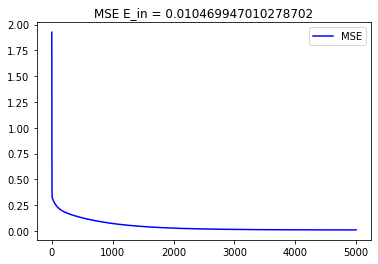

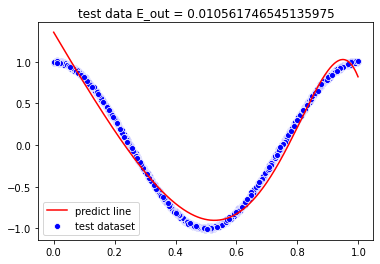

In [172]:
# test fitData_DG
import time
sigma = 0.1
N = 200
N_test = 2000
D = 10
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
print(f"x is {x.shape}, y is {y.shape}, A is {A.shape}")
(A, E_in, E_out) = fitData_DG(y, x, A, epochs = 5000, N_test=N_test, r = 0.1, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

#### fitData_SDG

In [ ]:
def fitData_SDG(Y_real, x, A, 
                 epochs=3000, 
                 r=0.01,
                 plot=True, 
                 N_test=2000, 
                 sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data
    N = x.size()[0] # get number of sample
    L = getMSE(Y_real, x, A)
    # print(f"fitData is SDG")
    while epoch < epochs:
        pickup = rd.randint(0, N-1)
        xi = torch.tensor([(x[pickup] ** i) for i in range(D+1)])
        dA = -2 * (Y_real[pickup] - torch.matmul(xi, A)) * xi
        # print(f"Y_real is {Y_real[pickup]}\n xi is {xi}\n A is {A}\n dA is {dA}\n")
        A = (A - r * dA).detach()
        L = getMSE(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE epoch E_in = {E_in}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

time cost is 3.8287792205810547


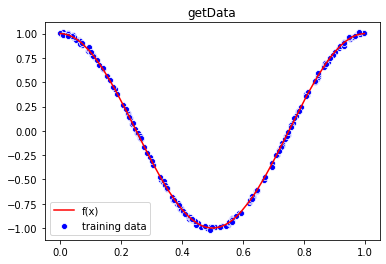

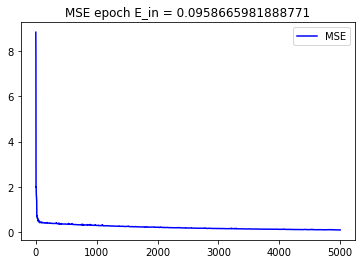

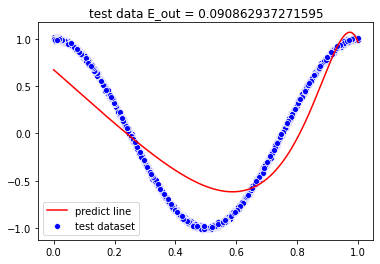

In [ ]:
# test fitData_SDG
import time
sigma = 0.1
N = 200
N_test = 2000
D = 20
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_SDG(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

#### fitData_mini

In [ ]:
def fitData_mini(Y_real, x, A, 
                 epochs=3000, 
                 r=0.001,  
                 plot=True, 
                 N_test=2000, 
                 batch=200,
                 sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data
    N = x.size()[0] # get number of all samples
    T = (int)(N / batch)
    # print(f"fitdata is mini batch SDG, {T} batch in one epoch")
    while epoch < epochs:
        for t in range(T):
            # print(f"get batch from {t * batch} to {(t+1) * batch}")
            Y_real_in_batch = Y_real[t * batch:(t+1) * batch]
            x_in_batch = x[t * batch: (t+1) * batch]
            L = getMSE(Y_real_in_batch, x_in_batch, A)
            L.backward()
            # DCG_node([A])
            A = (A - r * A.grad.data).detach()
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1
    
    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE epoch E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

time cost is 3.4771804809570312


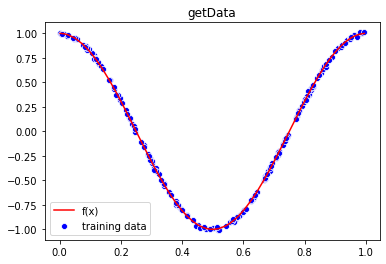

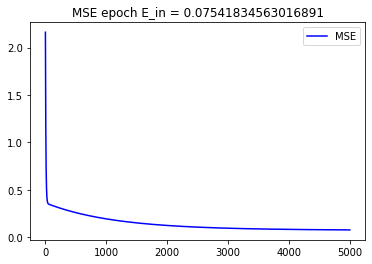

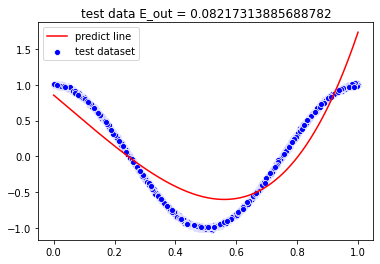

In [ ]:
# test fitData_mini
import time
sigma = 0.1
N = 200
N_test = 2000
D = 4
batch=100
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_mini(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, batch=batch, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

#### fitData

In [ ]:
def fitData(Y_real, x, A, 
            epochs=3000, 
            r=0.001,  
            batch=100,
            plot=True, 
            N_test=2000, 
            sigma=0.1,
            mode='dg'):
    if mode == 'DG' or mode == 'dg':
        return fitData_DG(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, sigma=sigma)
    if mode == 'sdg' or mode == 'SDG':
        return fitData_SDG(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, sigma=sigma)
    if mode == 'mini':
        return fitData_mini(Y_real, x, A, epochs=epochs, r=r,  
                    plot=plot, N_test=N_test, batch=batch, sigma=sigma)
    

time cost is 3.7284152507781982


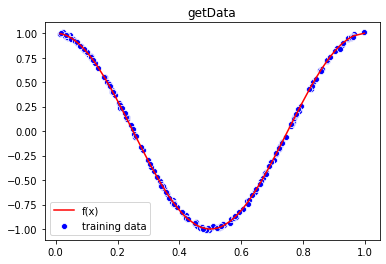

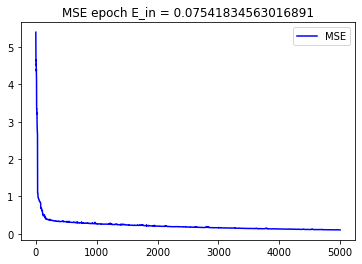

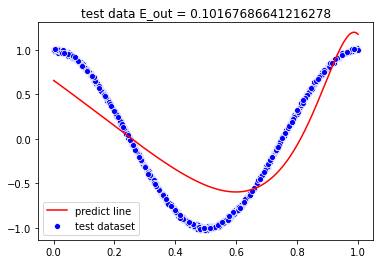

In [ ]:
# test fitData
import time
sigma = 0.1
N = 200
D = 20
batch=50
N_test = 1000
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData(y, x, A, 
                           epochs = 5000, 
                           N_test=N_test, 
                           r = 0.01, 
                           batch=batch, 
                           sigma=sigma,
                           mode='sdg')
endTime = time.time()
print(f"time cost is {endTime - startTime}")

### experiment
Write a function **experiment** that takes as input the size $N$ of training dataset, the degree $d$ of the model polynomial and noise variance $\sigma^2$, and does the following. For the given values of $N$, $d$ and $\sigma^2$, it loops over $M$ trials ($M$ not smaller than 20; say, 50 would be a decent number), where each trial is defined
as generating a training dataset of size $N$ and noise variance $\sigma^2$ (by calling **getData**) and then fitting the data to a polynomial of degree $d$ (by calling **fitData**). The computed $E_{in}$ and $E_{out}$ are respectively averaged
over the $M$ trials, which are denoted by $\overline{E}_{in}$ and $\overline{E}_{out}$. The obtained $M$ polynomials over the $M$ trials are also averaged. The function then generates another large dataset with noise variance $\sigma^2$ and computes the
average MSE for the dataset fitted to the average polynomial. This MSE will be denoted by $E_{bias}$. The function outputs $\overline{E}_{in}$, $\overline{E}_{out}$ and $E_{bias}$. These three values are the metrics that you will examine.

In [ ]:
# d from 0
def experiment(N, d, sigma, plot=False):
    M = 50
    E_in_total = torch.FloatTensor([0])
    E_out_total = torch.FloatTensor([0])
    A_total = torch.zeros(d+1)
    Ms = M
    while Ms > 0:
        trainset = getData(N, sigma, plot=False)
        x_train = torch.FloatTensor([xi for (xi, yi) in trainset])
        y_train = torch.FloatTensor([yi for (xi, yi) in trainset])
        A = torch.rand(d+1)
        (A, E_in, E_out) = fitData(y_train, x_train, A, 
                                    epochs=5000, 
                                    r=0.01,  
                                    batch=100,
                                    plot=False, 
                                    N_test=2000, 
                                    sigma=sigma,
                                    mode='sdg')
        E_in_total.add_(E_in)
        E_out_total.add_(E_out)
        A_total.add_(A)
        # print(f"E_in is {E_in_avg}, E_out is {E_out_avg}")
        Ms -= 1
    E_in_avg = torch.true_divide(E_in_total, torch.FloatTensor([M]))
    E_out_avg = torch.true_divide(E_out_total, torch.FloatTensor([M]))
    A_avg = torch.true_divide(A_total, torch.FloatTensor([M])).detach_()

    large_testset = getData(N * 10, sigma, plot=False)
    large_test_x = torch.FloatTensor([xi for (xi, yi) in large_testset])
    large_test_y = torch.FloatTensor([yi for (xi, yi) in large_testset])
    (mse, large_pred_y) = getMSE(large_test_y, large_test_x, A_avg, y_pred=True)
    large_pred_y.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.scatterplot(x=large_test_x, y=large_test_y, color='blue', label='large test dataset', ax=ax)
        sns.lineplot(x=large_test_x, y=large_pred_y, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {mse}")

    return ((E_in_avg.detach_().numpy()[0], E_out_avg.detach_().numpy()[0], mse))

E_in is 0.09782341867685318, E_out is 0.10027486085891724,
 E_bias is 0.09550768882036209


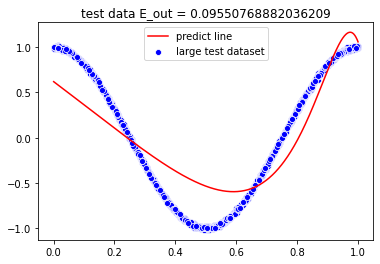

In [ ]:
(E_in, E_out, E_bias) = experiment(200, 20, 0.1, plot=True)
print(f"E_in is {E_in}, E_out is {E_out},\n E_bias is {E_bias}")

### analysis
Run experiment for all combinations of $N$, $d$, and $\sigma^2$, with $N \in \{2, 5, 10, 20, 50, 100, 200\}$, $d \in \{0, 1, 2 .... , 20\}$, $\sigma \in \{1, 0.1, 0.01\}$.  
Organize the results in plots and comment on what you observe regarding fitting and generalization of your models, in relation to model complexity ($d$), sample size ($N$), and noise level ($\sigma$). Note:
1. Plots under comparison should display the same Y-range.  
2. You do not need to plot all the results. Rather, you should carefully design the ways you plot your results so as to be the most illustrative and to fully reflect you understanding.

100%|██████████| 20/20 [31:31<00:00, 94.58s/it] 


Text(0.5, 0, 'model complexity')

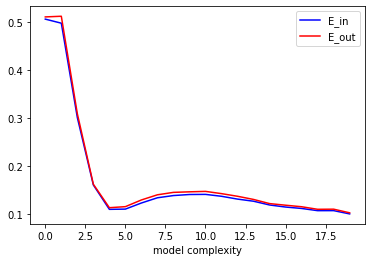

In [ ]:
from tqdm import tqdm

Ein = []
Eout = []
Ebias = []
dlist = []
for d in tqdm(range(20)):
    (E_in, E_out, E_bias) = experiment(200, d, 0.1)
    Ein.append(E_in)
    Eout.append(E_out)
    dlist.append(d)

fig, ax = plt.subplots()
sns.lineplot(x=dlist, y=Ein, color='blue', label='E_in', ax=ax)
sns.lineplot(x=dlist, y=Eout, color='red', label='E_out', ax=ax)
plt.xlabel('model complexity')

### weight decay
Revise your code to include weight decay regularization, and redo (E). Plot the results and comment
on what you observe.

In [ ]:
def getMSE_wd(Y_real, x, A, wd=0.1, y_pred=False):
    if A.grad != None:
        A.grad.data.zeros_()
    A.requires_grad = True
    D = A.size()[0] - 1
    N = x.size()[0]
    X = torch.cat(([(x ** i).view(N, 1) for i in range(D+1)]), dim=1)
    Y_pred = torch.matmul(X, A)
    tail = wd * torch.sum(A ** 2)
    # print(f"in getMSE: X is {X.size()}, A is {A.size()}, Y_pred is {Y_pred.size()}")
    if y_pred:
        return ((1 / N) * torch.sum((Y_real - Y_pred) ** 2) + tail, Y_pred)
    else:
        return (1 / N) * torch.sum((Y_real - Y_pred) ** 2) + tail

In [ ]:
# test it the result should be [1.7, 2.5, 6.7] after adding wd
x = torch.FloatTensor([0, 1, 2, 3])
Y_real = torch.FloatTensor([0, 2, 4, 9])
A = torch.tensor([1.0, 0, 1.0])
L = getMSE_wd(Y_real, x, A)
L.backward()
print(DCG_node([Y_real, x, A, L]))

In [ ]:
def fitData_DG(Y_real, x, A, 
               epochs=5000, 
               r=0.05,  
               wd = 0.1,
               plot=True, 
               N_test=2000, 
               sigma=0.1):
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] - 1 # get Dimension of data, degree-d
    N = x.size()[0] # get number of sample
    L = getMSE_wd(Y_real, x, A.detach_(), wd=wd)
    # print(f"fitData is DG")
    while epoch < epochs:
        L.backward()
        A = (A - r * A.grad.data).detach() # make A a leaf node
        L = getMSE_wd(Y_real, x, A, wd=wd)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # get E_out
    testdata = getData(N_test, sigma, plot=False)
    x = torch.FloatTensor([xi for (xi, yi) in testdata])
    y = torch.FloatTensor([yi for (xi, yi) in testdata])
    (E_out, y_pred) = getMSE_wd(y, x, A.detach_(), wd=wd, y_pred=True)
    y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        plt.title(f"test data E_out = {E_out}")
    return (A, L, E_out)

time cost is 3.4215784072875977


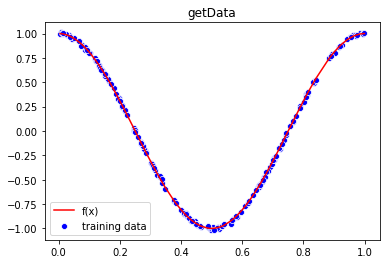

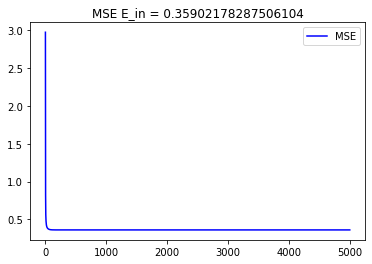

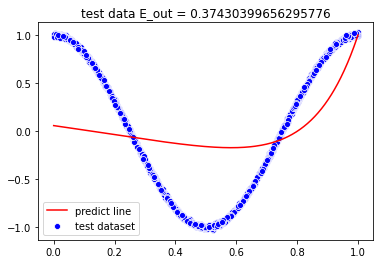

In [ ]:
# test fitData_DG
import time
sigma = 0.1
N = 200
N_test = 2000
D = 10
data = getData(N, sigma, plot=True)
x = torch.FloatTensor([xi for (xi, yi) in data])
y = torch.FloatTensor([yi for (xi, yi) in data])
A = torch.rand(D+1)
startTime = time.time()
(A, E_in, E_out) = fitData_DG(y, x, A, epochs = 5000, N_test=N_test, r = 0.1, sigma=sigma)
endTime = time.time()
print(f"time cost is {endTime - startTime}")

## use numpy
Y_real.shape = [N, 1]  
X_tmp.shape = [N, ]  
X.shape = [N, D]  
A.shape = [D, 1]  

### ngetMSE

In [39]:
# Y_real.shape = [N, 1]
# X.shape = [N, D]
# A.shape = [D, 1]
def ngetMSE(Y_real, X, A, y_pred=False):
    N = Y_real.shape[0]
    D = A.shape[0]
    Y_pred = X @ A
    L = (1 / N) * (np.sum((Y_real - X @ A) ** 2))
    if y_pred:
        return (L, Y_pred)
    else:
        return L

### back propogation

In [40]:
def back_prop(Y, X, A):
    N = Y.shape[0]
    # return (- 2 / N) * ((Y.T - A.T @ X.T) @ X).T
    return (-2 / N) * (X.T @ (Y - X @ A))

In [41]:
# test it the result should be [1.5, 2.5, 6.5]
D = 3
X_tmp = np.array([0, 1, 2, 3])
Y_real = np.array([[0, 2, 4, 9]]).T
X = np.array([X_tmp ** i for i in range(D)]).T
A = np.array([[1, 0, 1]]).T
print(f"X is {X.shape}, Y_real is {Y_real.shape}, \
A is {A.shape}")
print(back_prop(Y_real, X, A))

X is (4, 3), Y_real is (4, 1), A is (3, 1)
[[1.5]
 [2.5]
 [6.5]]


### nfitData

Y_real.shape = [N, 1]  get from getData, real data  
X.shape = [N, D]  X_tmp ^ degree  
X_tmp.shape = [N, ] get from getData, real data    
A.shape = [D, 1]

In [78]:
def nfitData(Y, X_tmp, A, epochs=3000, lr = 0.1, plot=True, N_test=5000, sigma=0.1):
    e = 0
    LList = []
    epochList = []
    N = Y.shape[0]
    D = A.shape[0]
    X = np.array([X_tmp ** i for i in range(D)]).T
    print(f"in: A is {A.shape}, N is {N}, X is {X.shape}, Y is {Y.shape}")
    while(e < epochs):
        A = A - lr * (-2 / N) * (X.T @ (Y - X @ A))
        L = ngetMSE(Y, X, A)
        LList.append(L)
        epochList.append(e)
        e += 1

    test_data = getData(N_test, sigma, plot=False)
    Xtest_tmp = np.array([xi for (xi, yi) in test_data])
    Xtest = np.array([Xtest_tmp ** i for i in range(D)]).T
    Ytest_real = np.array([[yi for (xi, yi) in test_data]]).T
    # print(f"Ytest_real is {Ytest_real.shape}, \
    # Xtest is {Xtest.shape}, A is {A.shape}")
    E_out = ngetMSE(Ytest_real, Xtest, A, y_pred=False)
        
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=Xtest_tmp, y=Ytest_real.flatten(), color='blue', label = 'test dataset', ax=ax)
        sns.lineplot(x=Xtest_tmp, y=(Xtest @ A).flatten(), color='red', label = 'pred curve', ax=ax)
        plt.title(f"MSE E_out = {E_out}")

    return (A, L, E_out)
        

Y_real is (200, 1), X_tmp is (200,), A is (10, 1)
in: A is (10, 1), N is 200, X is (200, 10), Y is (200, 1)


(array([[ 1.15333684],
        [-5.45649292],
        [ 0.92373939],
        [ 2.81064023],
        [ 2.74514338],
        [ 1.48565588],
        [ 0.92551613],
        [-0.38683899],
        [-1.35004574],
        [-1.69349451]]), 0.01996654315243463, 0.02181735739887879)

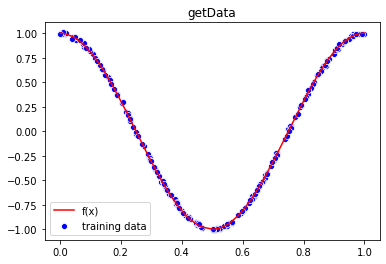

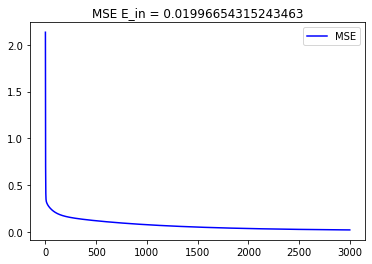

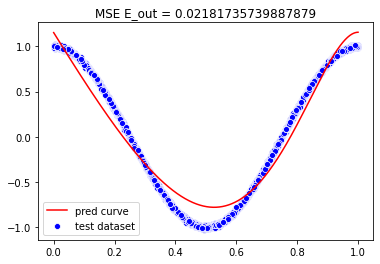

In [79]:
# test nfitData
import time
sigma = 0.1
N = 200
N_test = 2000
D = 10
data = getData(N, sigma, plot=True)
X_tmp = np.array([xi for (xi, yi) in data])
Y_real = np.array([[yi for (xi, yi) in data]]).T
A = np.random.rand(D, 1)
print(f"Y_real is {Y_real.shape}, X_tmp is {X_tmp.shape}, A is {A.shape}")
nfitData(Y_real, X_tmp, A)
# startTime = time.time()
# (A, E_in, E_out) = fitData_DG(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, sigma=sigma)
# endTime = time.time()
# print(f"time cost is {endTime - startTime}")

### nexperiment

In [10]:
# d from 0

def nexperiment(N, d, sigma, plot=False):
    M = 50
    E_in_total = 0
    E_out_total = 0
    A_total = np.zeros((d+1, 1))
    # generate A_avg
    for Ms in range(M):
        trainset = getData(N, sigma, plot=False)
        x_train = np.array([xi for (xi, yi) in trainset])
        y_train = np.array([[yi for (xi, yi) in trainset]]).T
        A = np.random.rand(d + 1, 1)
        (A, E_in, E_out) = nfitData(y_train, x_train, A, 
                 epochs=3000, 
                 lr = 0.1, 
                 plot=False, 
                 N_test=5000, 
                 sigma=sigma)
        E_in_total += E_in
        E_out_total += E_out
        A_total += A
    E_in_avg = E_in_total / M
    E_out_avg = E_out_total / M
    A_avg = A_total / M

    ## use A_avg to test
    large_testset = getData(N * 10, sigma, plot=False)
    large_test_x = np.array([xi for (xi, yi) in large_testset])
    large_test_y = np.array([[yi for (xi, yi) in large_testset]]).T
    large_test_expand_X = np.array([large_test_x ** i for i in range(d+1)]).T
    # print(f"large_test_y is {large_test_y.shape},\
    # large_test_expand_X is {large_test_expand_X.shape},\
    # A_avg is {A_avg.shape}")
    L_out = ngetMSE(large_test_y, large_test_expand_X, A_avg)

    if plot:
        fig, ax = plt.subplots()
        sns.scatterplot(x=large_test_x, y=large_test_y.flatten(), color='blue', label='large test dataset', ax=ax)
        sns.lineplot(x=large_test_x, y=(large_test_expand_X @ A).flatten(), color='red', label='predict line', ax=ax)
        plt.title(f"test data E_bias = {L_out}")

    return (E_in_avg, E_out_avg, L_out)

E_in is 0.02428501221429924, E_out is 0.026791409103645646,
 E_bias is 0.024622268821248385


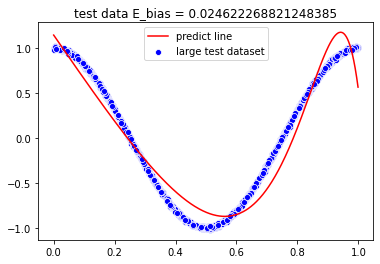

In [11]:
(E_in, E_out, E_bias) = nexperiment(200, 20, 0.1, plot=True)
print(f"E_in is {E_in}, E_out is {E_out},\n E_bias is {E_bias}")

### analysis

#### check E_in, E_out against model complexity

In [12]:
from tqdm import tqdm

Ein = []
Eout = []
Ebias = []
dlist = []
for d in tqdm(range(40)):
    (E_in, E_out, E_bias) = nexperiment(50, d, 0.5)
    Ein.append(E_in)
    Eout.append(E_out)
    dlist.append(d)

fig, ax = plt.subplots()
sns.lineplot(x=dlist, y=Ein, color='blue', label='E_in', ax=ax)
sns.lineplot(x=dlist, y=Eout, color='red', label='E_out', ax=ax)
plt.xlabel('model complexity')

  0%|          | 0/40 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

#### E_in, E_out versus N

Text(0.5, 0, 'sample size N')

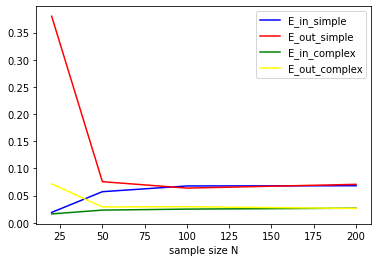

In [ ]:
from tqdm import tqdm

Ein = []
Eout = []
Nlist = []

# for a simple model, set d = 5
for N in [20, 50, 100, 200]:
    (E_in, E_out, E_bias) = nexperiment(N, 5, 0.1)
    Ein.append(E_in)
    Eout.append(E_out)
    Nlist.append(N)

fig, ax = plt.subplots()
sns.lineplot(x=Nlist, y=Ein, color='blue', label='E_in_simple', ax=ax)
sns.lineplot(x=Nlist, y=Eout, color='red', label='E_out_simple', ax=ax)
plt.xlabel('sample size N')

# for a complex model, set d = 20
Ein = []
Eout = []

for N in [20, 50, 100, 200]:
    (E_in, E_out, E_bias) = nexperiment(N, 20, 0.1)
    Ein.append(E_in)
    Eout.append(E_out)

sns.lineplot(x=Nlist, y=Ein, color='green', label='E_in_complex', ax=ax)
sns.lineplot(x=Nlist, y=Eout, color='yellow', label='E_out_complex', ax=ax)
plt.xlabel('sample size N')

### weight decay regularization

##### ngetMSE_wd

In [13]:
# Y_real.shape = [N, 1]
# X.shape = [N, D]
# A.shape = [D, 1]
def ngetMSE_wd(Y_real, X, A, wd=-0.1, y_pred=False):
    N = Y_real.shape[0]
    D = A.shape[0]
    Y_pred = X @ A
    L = (1 / N) * (np.sum((Y_real - X @ A) ** 2)) + (wd * np.sum(A ** 2))
    if y_pred:
        return (L, Y_pred)
    else:
        return L

In [15]:
def back_prop(Y, X, A, wd=-0.1):
    N = Y.shape[0]
    # return (- 2 / N) * ((Y.T - A.T @ X.T) @ X).T
    return (-2 / N) * (X.T @ (Y - X @ A)) + 2 * wd * A

In [16]:
# test it the result should be [1.7, 2.5, 6.7]
D = 3
X_tmp = np.array([0, 1, 2, 3])
Y_real = np.array([[0, 2, 4, 9]]).T
X = np.array([X_tmp ** i for i in range(D)]).T
A = np.array([[1, 0, 1]]).T
print(f"X is {X.shape}, Y_real is {Y_real.shape}, \
A is {A.shape}")
print(back_prop(Y_real, X, A))

X is (4, 3), Y_real is (4, 1), A is (3, 1)
[[1.3]
 [2.5]
 [6.3]]


##### nfitData_wd

In [38]:
def nfitData_wd(Y, X_tmp, A, epochs=3000, wd=0.001, lr = 0.1, plot=True, N_test=5000, sigma=0.1):
    e = 0
    LList = []
    epochList = []
    N = Y.shape[0]
    D = A.shape[0]
    X = np.array([X_tmp ** i for i in range(D)]).T
    while(e < epochs):
        A = A - lr * ((-2 / N) * (X.T @ (Y - X @ A)) + 2 * wd * A)
        L = ngetMSE_wd(Y, X, A, wd=wd)
        LList.append(L)
        epochList.append(e)
        e += 1

    test_data = getData(N_test, sigma, plot=False)
    Xtest_tmp = np.array([xi for (xi, yi) in test_data])
    Xtest = np.array([Xtest_tmp ** i for i in range(D)]).T
    Ytest_real = np.array([[yi for (xi, yi) in test_data]]).T
    # print(f"Ytest_real is {Ytest_real.shape}, \
    # Xtest is {Xtest.shape}, A is {A.shape}")
    E_out = ngetMSE_wd(Ytest_real, Xtest, A, wd=wd, y_pred=False)
        
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        fig, ax = plt.subplots()
        sns.scatterplot(x=Xtest_tmp, y=Ytest_real.flatten(), color='blue', label = 'test dataset', ax=ax)
        sns.lineplot(x=Xtest_tmp, y=(Xtest @ A).flatten(), color='red', label = 'pred curve', ax=ax)
        plt.title(f"MSE E_out = {E_out}")

    return (A, L, E_out)

Y_real is (200, 1), X_tmp is (200,), A is (10, 1)


(array([[ 1.0250625 ],
        [-4.51269018],
        [ 0.24848752],
        [ 2.35686873],
        [ 2.25177207],
        [ 1.46914699],
        [ 0.81562535],
        [-0.10985205],
        [-0.70582888],
        [-1.54116076]]), 0.07780707802319572, 0.078511075725026)

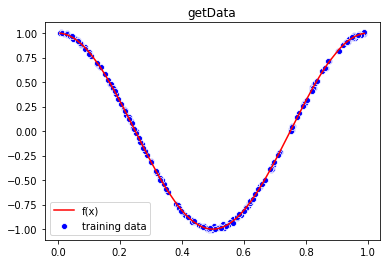

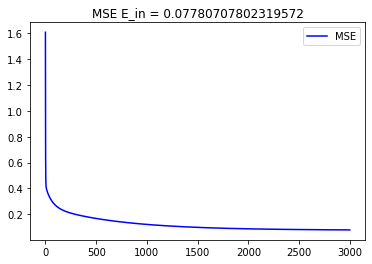

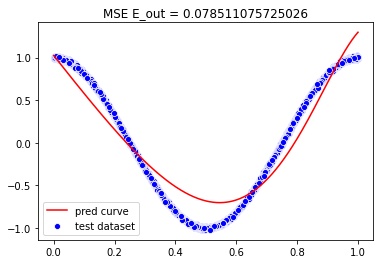

In [26]:
# test nfitData_wd
import time
sigma = 0.1
N = 200
N_test = 2000
D = 10
data = getData(N, sigma, plot=True)
X_tmp = np.array([xi for (xi, yi) in data])
Y_real = np.array([[yi for (xi, yi) in data]]).T
A = np.random.rand(D, 1)
print(f"Y_real is {Y_real.shape}, X_tmp is {X_tmp.shape}, A is {A.shape}")
nfitData_wd(Y_real, X_tmp, A)

##### nexperiment_wd

In [ ]:
def nexperiment_wd(N, d, sigma, wd, plot=False):
    M = 50
    E_in_total = 0
    E_out_total = 0
    A_total = np.zeros((d+1, 1))
    # generate A_avg
    for Ms in range(M):
        trainset = getData(N, sigma, plot=False)
        x_train = np.array([xi for (xi, yi) in trainset])
        y_train = np.array([[yi for (xi, yi) in trainset]]).T
        A = np.random.rand(d + 1, 1)
        (A, E_in, E_out) = nfitData_wd(y_train, x_train, A, 
                 epochs=3000, 
                 lr = 0.1, 
                 plot=False, 
                 N_test=5000, 
                 wd = wd,
                 sigma=sigma)
        E_in_total += E_in
        E_out_total += E_out
        A_total += A
    E_in_avg = E_in_total / M
    E_out_avg = E_out_total / M
    A_avg = A_total / M

    ## use A_avg to test
    large_testset = getData(N * 10, sigma, plot=False)
    large_test_x = np.array([xi for (xi, yi) in large_testset])
    large_test_y = np.array([[yi for (xi, yi) in large_testset]]).T
    large_test_expand_X = np.array([large_test_x ** i for i in range(d+1)]).T
    # print(f"large_test_y is {large_test_y.shape},\
    # large_test_expand_X is {large_test_expand_X.shape},\
    # A_avg is {A_avg.shape}")
    L_out = ngetMSE_wd(large_test_y, large_test_expand_X, A_avg, wd=wd)

    if plot:
        fig, ax = plt.subplots()
        sns.scatterplot(x=large_test_x, y=large_test_y.flatten(), color='blue', label='large test dataset', ax=ax)
        sns.lineplot(x=large_test_x, y=(large_test_expand_X @ A).flatten(), color='red', label='predict line', ax=ax)
        plt.title(f"test data E_bias = {L_out}")

    return (E_in_avg, E_out_avg, L_out)

E_in is 0.06175923965839383, E_out is 0.07260854821258328,
 E_bias is 0.06484191238701144


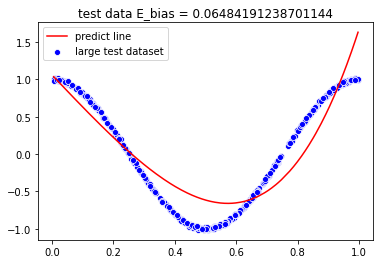

In [ ]:
(E_in, E_out, E_bias) = nexperiment_wd(50, 4, 0.1, wd=0.0001, plot=True)
print(f"E_in is {E_in}, E_out is {E_out},\n E_bias is {E_bias}")

E_in is 0.057222242737971864, E_out is 0.07027612869559267,
 E_bias is 0.06251934939544525


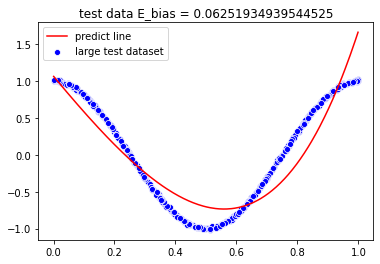

In [ ]:
(E_in, E_out, E_bias) = nexperiment(50, 4, 0.1, plot=True)
print(f"E_in is {E_in}, E_out is {E_out},\n E_bias is {E_bias}")

## check numpy and pytorch

### getMSE

In [162]:
# MSE = (1/N) sum ((Y - (1, x, x ^ 2, ... x ^ d) * A) ^ 2)
# A.size() = (d, 1)
# x.size() = (N, 1)
# Y_real.size() = (N, 1)
def getMSE_test(Y_real, x, A, y_pred=False):
    if A.grad != None:
        A.grad.data.zeros_()
    A.requires_grad = True
    D = A.size()[0]
    N = x.size()[0]
    X = torch.cat(([(x ** i).view(N, 1) for i in range(D)]), dim=1)
    # print(f"MSE test: A is {A.size()}, X is {X.size()}")
    Y_pred = torch.matmul(X, A)
    # print(f"in getMSE: X is {X.size()}, A is {A.size()}, Y_pred is {Y_pred.size()}")
    if y_pred:
        return ((1 / N) * torch.sum((Y_real - Y_pred) ** 2), Y_pred)
    else:
        return (1 / N) * torch.sum((Y_real - Y_pred) ** 2)

In [140]:
def ngetMSE_test(Y_real, X, A, y_pred=False):
    N = Y_real.shape[0]
    D = A.shape[0]
    Y_pred = X @ A
    L = (1 / N) * (np.sum((Y_real - X @ A) ** 2))
    if y_pred:
        return (L, Y_pred)
    else:
        return L

### fitData

In [166]:
def fitData_DG_test(Y_real, x, A, 
               epochs=3000, 
               r=0.1,  
               plot=True):
    print(f"torch fit: A is {A.size()}, x is {x.size()}, \
    Y_real is {Y_real.size()}, ")
    LList = []
    epochList = []
    epoch = 0
    D = A.size()[0] # get Dimension of data, degree-d
    N = x.size()[0] # get number of sample
    L = getMSE_test(Y_real, x, A.detach_())
    while epoch < epochs:
        L.backward()
        A = (A - r * A.grad.data).detach() # make A a leaf node
        L = getMSE_test(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1

    # # get E_out
    # testdata = getData(N_test, sigma, plot=False)
    # x = torch.FloatTensor([xi for (xi, yi) in testdata])
    # y = torch.FloatTensor([yi for (xi, yi) in testdata])
    # (E_out, y_pred) = getMSE(y, x, A.detach_(), y_pred=True)
    # y_pred.detach_()

    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"torch E_in = {L}")
        # fig, ax = plt.subplots()
        # sns.scatterplot(x=x, y=y, color='blue', label='test dataset', ax=ax)
        # sns.lineplot(x=x, y=y_pred, color='red', label='predict line', ax=ax)
        # plt.title(f"test data E_out = {E_out}")
    return (A, L)

In [154]:
def nfitData_test(Y, X_tmp, A, epochs=3000, lr = 0.1, plot=True):
    e = 0
    LList = []
    epochList = []
    N = Y.shape[0]
    D = A.shape[0]
    X = np.array([X_tmp ** i for i in range(D)]).T
    print(f"numpy fit: A is {A.shape}, N is {N}, X is {X.shape}, Y is {Y.shape}")
    while(e < epochs):
        A = A - lr * (-2 / N) * (X.T @ (Y - X @ A))
        L = ngetMSE_test(Y, X, A)
        LList.append(L)
        epochList.append(e)
        e += 1

    # test_data = getData(N_test, sigma, plot=False)
    # Xtest_tmp = np.array([xi for (xi, yi) in test_data])
    # Xtest = np.array([Xtest_tmp ** i for i in range(D)]).T
    # Ytest_real = np.array([[yi for (xi, yi) in test_data]]).T
    # # print(f"Ytest_real is {Ytest_real.shape}, \
    # # Xtest is {Xtest.shape}, A is {A.shape}")
    # E_out = ngetMSE(Ytest_real, Xtest, A, y_pred=False)
        
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title(f"MSE E_in = {L}")
        # fig, ax = plt.subplots()
        # sns.scatterplot(x=Xtest_tmp, y=Ytest_real.flatten(), color='blue', label = 'test dataset', ax=ax)
        # sns.lineplot(x=Xtest_tmp, y=(Xtest @ A).flatten(), color='red', label = 'pred curve', ax=ax)
        # plt.title(f"MSE E_out = {E_out}")

    return (A, L, E_out)
        
        

### test

numpy fit: A is (10, 1), N is 200, X is (200, 10), Y is (200, 1)
torch fit: A is torch.Size([10]), x is torch.Size([200]),     Y_real is torch.Size([200]), 


(tensor([ 1.1730, -5.3413,  0.4315,  2.7003,  2.9745,  2.1127,  0.9447, -0.3779,
         -1.3373, -2.1873], requires_grad=True),
 tensor(0.0186, grad_fn=<MulBackward0>))

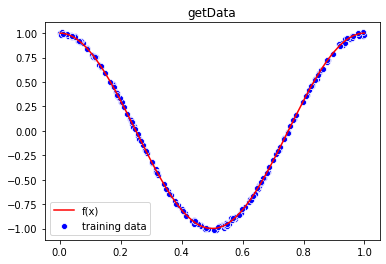

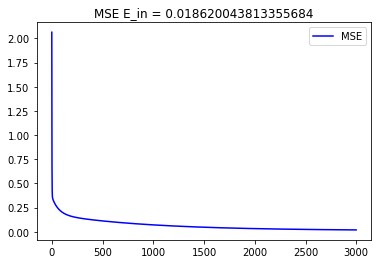

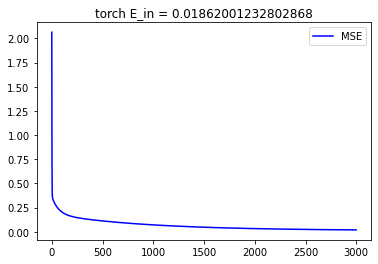

In [167]:
# test nfitData
import time
sigma = 0.1
N = 200
D = 10
lr = 0.1
ep = 3000
data = getData(N, sigma, plot=True)

random_value = np.random.rand(D)

x_numpy = np.array([xi for (xi, yi) in data])
y_numpy = np.array([[yi for (xi, yi) in data]]).T
A_numpy = np.array([random_value]).T
nfitData_test(y_numpy, x_numpy, A_numpy, epochs=ep, lr=lr)

x_torch = torch.FloatTensor([xi for (xi, yi) in data])
y_torch = torch.FloatTensor([yi for (xi, yi) in data])
A_torch = torch.FloatTensor(random_value)
fitData_DG_test(y_torch, x_torch, A_torch)
#MSE test: A is torch.Size([11]), X is torch.Size([200, 11])

in: A is (10, 1), N is 200, X is (200, 10), Y is (200, 1)


(array([[ 0.64120707],
        [-2.32578332],
        [-0.57385222],
        [ 0.68733627],
        [ 1.23241129],
        [ 0.37142237],
        [ 0.60010926],
        [ 0.79016478],
        [ 0.14121667],
        [ 0.36130156]]), 0.13973150079778626, 0.14901468900188558)

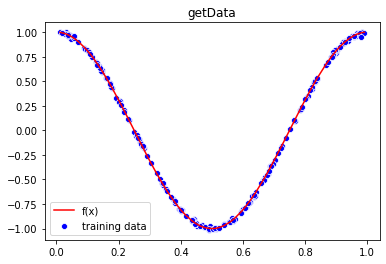

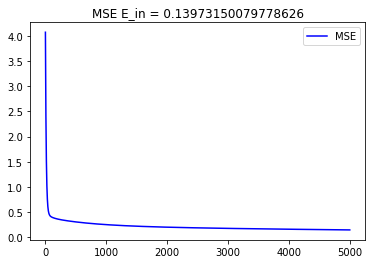

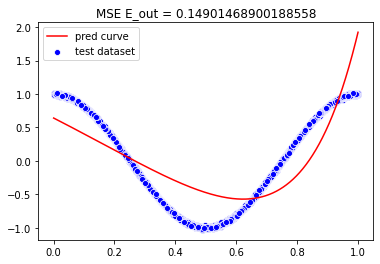

In [81]:
sigma = 0.1
N = 200
N_test = 2000
D = 10
data = getData(N, sigma, plot=True)
x_numpy = np.array([xi for (xi, yi) in data])
y_numpy = np.array([[yi for (xi, yi) in data]]).T
A_numpy = np.random.rand(D, 1)
nfitData_test(y_numpy, x_numpy, A_numpy, epochs=5000, lr=0.01, sigma=sigma)
# startTime = time.time()
# (A, E_in, E_out) = fitData_DG(y, x, A, epochs = 5000, N_test=N_test, r = 0.01, sigma=sigma)
# endTime = time.time()
# print(f"time cost is {endTime - startTime}")



# test fitData_DG
# common values
# import time
# sigma = 0.1
# N = 200
# epch = 5000
# D = 10
# data = getData(N, sigma, plot=True)
# x_torch = torch.FloatTensor([xi for (xi, yi) in data])
# y_torch = torch.FloatTensor([yi for (xi, yi) in data])
# x_numpy = np.array([xi for (xi, yi) in data])
# y_numpy = np.array([[yi for (xi, yi) in data]]).T
# A_torch = torch.rand(D)
# A_numpy = np.array([A_torch.numpy()]).T
# print(f"x_torch is {x_torch},\n  x_numpy is {x_numpy},\n  \
# y_torch is {y_torch},\n y_numpy is {y_numpy},\n \
# A_torch is {A_torch},\n A_numpy is {A_numpy},\n")

# (A_torch_finial, Ein_torch) = fitData_DG_test(y_torch, x_torch, A_torch, epochs = epch, r = 0.01, sigma=sigma)
# print(f"y_numpy is {y_numpy.shape}, x_numpy is {x_numpy.shape}, A_numpy is {A_numpy.shape}")
# (A_numpy_finial, Ein_numpy) = nfitData_test(y_numpy, x_numpy, A_numpy, epochs=epch, lr=0.01, sigma=sigma)



push to github